#Install the required libraries

```
```



In [ ]:
#if you're using google colab you'll need to run this cell everytime

#Install the required libraries

#install talib google colab

!wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
!tar -xzvf ta-lib-0.4.0-src.tar.gz
%cd ta-lib
!./configure --prefix=/usr
!make
!make install
!pip install Ta-Lib

--2022-05-11 15:41:48--  http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
Resolving prdownloads.sourceforge.net (prdownloads.sourceforge.net)... 204.68.111.105
Connecting to prdownloads.sourceforge.net (prdownloads.sourceforge.net)|204.68.111.105|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz [following]
--2022-05-11 15:41:48--  http://downloads.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz
Resolving downloads.sourceforge.net (downloads.sourceforge.net)... 204.68.111.105
Reusing existing connection to prdownloads.sourceforge.net:80.
HTTP request sent, awaiting response... 302 Found
Location: http://versaweb.dl.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz [following]
--2022-05-11 15:41:48--  http://versaweb.dl.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz
Resolving versaweb.dl.s

In [ ]:
#install yfinance

!pip install yfinance

     |████████████████████████████████| 6.4 MB 7.9 MB/s 
     |████████████████████████████████| 63 kB 1.6 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.27.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [ ]:
# import all necessary libraries

import pandas as pd
pd.set_option('display.max_rows', None)
import numpy as np
from datetime import datetime
import time
import talib
from talib import abstract
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
from scipy.signal import argrelextrema
from scipy.stats import linregress
from scipy.optimize import curve_fit
import json
import requests
import datetime as dt
import time
import yfinance as yf  

#Start pulling data

In [ ]:
# import OHLC data from glassnode going back to 2013

# API key here
API_KEY = '' #insert your glassnode API KEY here

# report end dates

#yesterday = dt.date.today() - dt.timedelta(days=1)
#unixtimeyesterday = round(time.mktime(yesterday.timetuple()))

today = dt.date.today()
unixtimetoday = round(time.mktime(today.timetuple()))


# make API request
res = requests.get('https://api.glassnode.com/v1/metrics/market/price_usd_ohlc',
        params={'a': 'BTC', 'api_key': API_KEY, 's': '1278716400', 'u': unixtimetoday,
            'i': '24h','f':'JSON', 'timestamp_format':'unix'})

# convert to pandas dataframe
df = pd.read_json(res.text)

In [ ]:
# rework df to explode price dictionary into multiple columns and rename them

# split OHLC dictionary into multiple columns

df_glasnode_ohlc = pd.json_normalize(df['o'])

# append exploded ohlc values into the original df

df = pd.concat([df.drop(['o'], axis=1), df_glasnode_ohlc], axis=1)

# rename the columns

df = df.rename(columns={'t':'date','c':'close','h':'high', 'l':'low', 'o':'open'})

In [ ]:
# transform unix to UTC

df['date'] = pd.to_datetime(df['date'],unit='s')

In [ ]:
# reorder columns

df = df[['date','open', 'high', 'low', 'close']]

In [ ]:
# check if we're ready to start working with bitcoin daily price data since 2013...

df.tail()

,date,open,high,low,close
4311,2022-05-06,36566.667655,36580.241034,35509.211551,36054.160121
4312,2022-05-07,36039.538853,36124.561488,34944.427399,35542.908407
4313,2022-05-08,35490.533652,35490.533652,33890.436592,33987.641361
4314,2022-05-09,34070.852625,34203.515788,30339.983987,30384.579816
4315,2022-05-10,30187.990644,32596.307836,29978.213616,31007.755089


#Mayer Multiple Section

In [ ]:
# calculate some momentum indicators

rsi = talib.RSI(df['close'], timeperiod=14)

fifty_sma = talib.SMA(df['close'], timeperiod=50)

twohundred_sma = talib.SMA(df['close'], timeperiod=200)

macd, macdsignal, macdhist = talib.MACD(df['close'], fastperiod=12, slowperiod=26, signalperiod=9)

fastk, fastd = talib.STOCHRSI(df['close'], timeperiod=14, fastk_period=5, fastd_period=3, fastd_matype=0)

In [ ]:
# add new fields to base dataframe

df['RSI'] = rsi
df['50SMA'] = fifty_sma
df['200SMA'] = twohundred_sma
df['MACD'] = macd
df['MACDSignal'] = macdsignal
df['MACDHist'] = macdhist
df['StochRSIFastk'] = fastk
df['StochRSIFastd'] = fastd

In [ ]:
# add Mayer multiple indicator

df['mayer_multiple']=df['close']/df['200SMA']

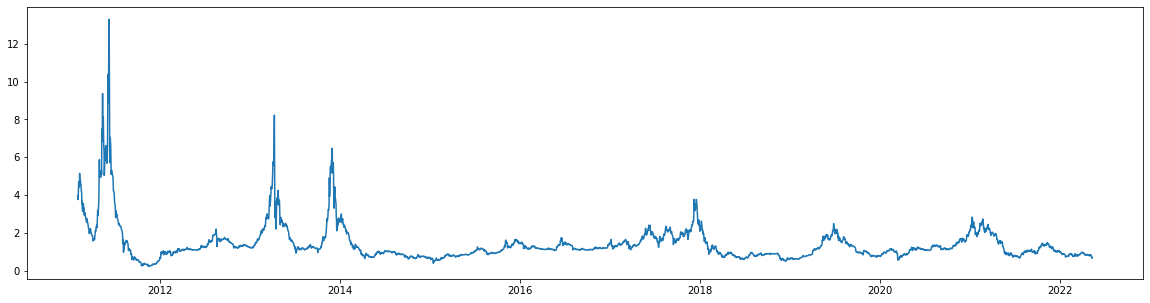

In [ ]:
# plot mayer multiple

fig, ax = plt.subplots(figsize=(20,5))

ax.plot(df['date'],df['mayer_multiple'])

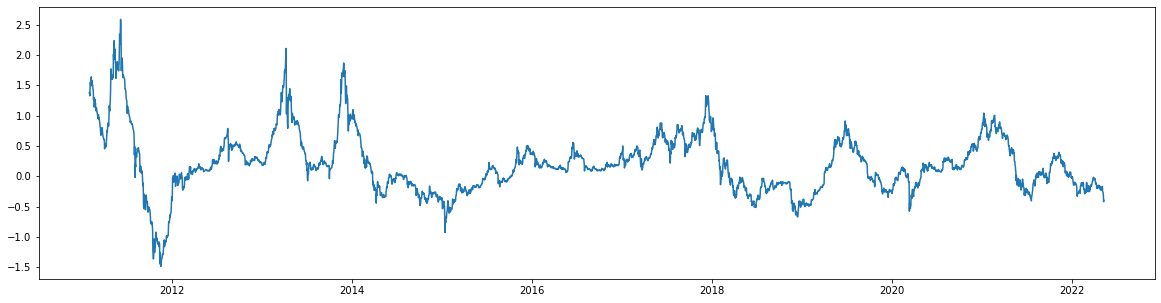

In [ ]:
# plot mayer multiple with logarithmic transformation 
# reason https://charts.woobull.com/bitcoin-mayer-multiple/ and https://twitter.com/PrfDude/status/1482062792203067393

fig, ax = plt.subplots(figsize=(20,5))

ax.plot(df['date'],np.log(df['mayer_multiple']))

In [ ]:
# add a new column with the logarithm of the mayer multiple

df['log_mayer_multiple'] = np.log(df['mayer_multiple'])

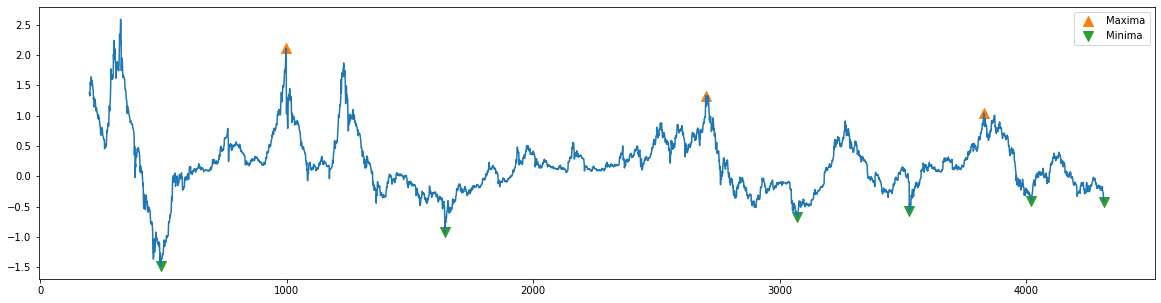

In [ ]:
# plot local maxima and minima using https://medium.com/raposa-technologies/higher-highs-lower-lows-and-calculating-price-trends-in-python-9bc9703f46a1

from scipy.signal import argrelextrema

mayer_max_idx = argrelextrema(df['log_mayer_multiple'].values, 
  np.greater, order=600)[0]
mayer_min_idx = argrelextrema(df['log_mayer_multiple'].values, 
  np.less, order=270)[0]

fig, ax = plt.subplots(figsize=(20,5))

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

ax.plot(np.log(df['mayer_multiple']))
ax.scatter(df.iloc[mayer_max_idx].index, df.iloc[mayer_max_idx]['log_mayer_multiple'],
  label='Maxima', s=100, color=colors[1], marker='^')
ax.scatter(df.iloc[mayer_min_idx].index, df.iloc[mayer_min_idx]['log_mayer_multiple'],
  label='Minima', s=100, color=colors[2], marker='v')
ax.legend()


In [ ]:
# create pd series with log mayer multiple highs and lows

mayer_highs = df.iloc[mayer_max_idx]['log_mayer_multiple']
mayer_lows = df.iloc[mayer_min_idx]['log_mayer_multiple']

print(mayer_highs)

997     2.107553
2700    1.328027
3828    1.041067
Name: log_mayer_multiple, dtype: float64


In [ ]:
#add the initial high in log mayer multiple

mayer_init_max_idx = df['log_mayer_multiple'].idxmax()
mayer_init_max_value = df['log_mayer_multiple'].max()

print(mayer_init_max_idx)
print(mayer_init_max_value)

326
2.5875313569819247


In [ ]:
# build a pandas series with the initial max

mayer_highs_init_max = pd.Series([2.5875313569819247], index=[326])

In [ ]:
# concatenate the initial log mayer max with the rest of local maximums

mayer_highs = mayer_highs_init_max.append(mayer_highs)
print(mayer_highs)

326     2.587531
997     2.107553
2700    1.328027
3828    1.041067
dtype: float64


In [ ]:
# transform high and low series to dataframe, to then calculate a linear regression across them

mayer_highs = pd.DataFrame(mayer_highs)

mayer_lows = pd.DataFrame(mayer_lows)

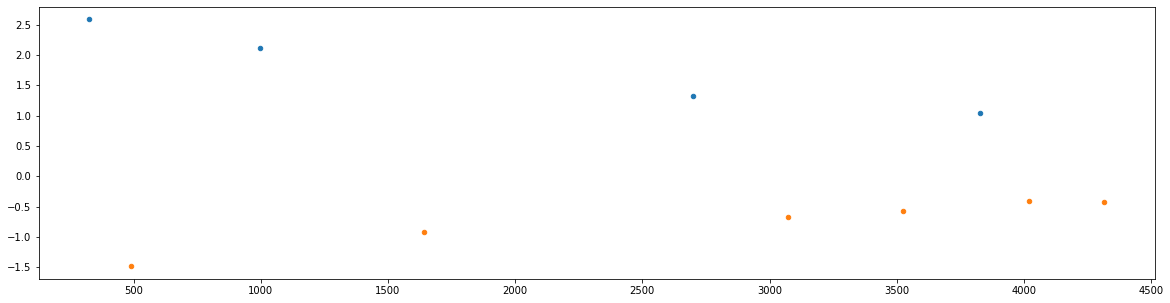

In [ ]:
#plot maxima and minima of the log mayer multiple

fig, ax = plt.subplots(figsize=(20,5))

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

ax.scatter(mayer_highs.index, mayer_highs[0], s=20)
ax.scatter(mayer_lows.index, mayer_lows['log_mayer_multiple'], s=20)

In [ ]:
# Function to calculate the exponential with constants a and b
def exponential(x, a, b):
    return a*np.exp(b*x)

# from https://towardsdatascience.com/basic-curve-fitting-of-scientific-data-with-python-9592244a2509

from scipy.optimize import curve_fit
x_top = mayer_highs.index
y_top = mayer_highs[0]

x_low = mayer_lows.index
y_low = mayer_lows['log_mayer_multiple']

#Fit the dummy exponential data
pars, cov = curve_fit(f=exponential, xdata=x_top, ydata=y_top, p0=[0, 0], bounds=(-np.inf, np.inf))

x_low = mayer_lows.index
y_low = mayer_lows['log_mayer_multiple']

#Fit the dummy exponential data
pars_low, cov_low = curve_fit(f=exponential, xdata=x_low, ydata=y_low, p0=[0, 0], bounds=(-np.inf, np.inf))




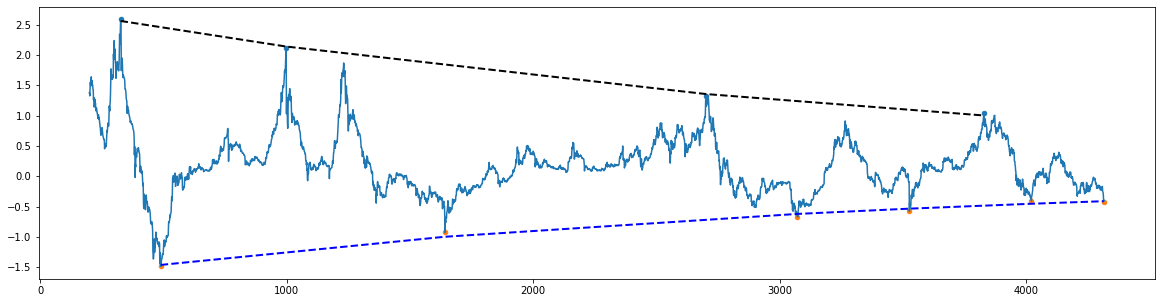

In [ ]:
# Plot the fit data as an overlay on the scatter data

fig, ax = plt.subplots(figsize=(20,5))
ax.plot(np.log(df['mayer_multiple']))
ax.plot(x_top, exponential(x_top, *pars), linestyle='--', linewidth=2, color='black')
ax.plot(x_low, exponential(x_low, *pars_low), linestyle='--', linewidth=2, color='blue')
ax.scatter(mayer_highs.index, mayer_highs[0], s=20)
ax.scatter(mayer_lows.index, mayer_lows['log_mayer_multiple'], s=20)
plt.show()

In [ ]:
# define log top band and log lower band

#df['mayer_topband'] = slope * df.index + intercept

x = df.index

df['log_mayer_topband'] = exponential(x, *pars)
df['log_mayer_lowerband'] = exponential(x, *pars_low)


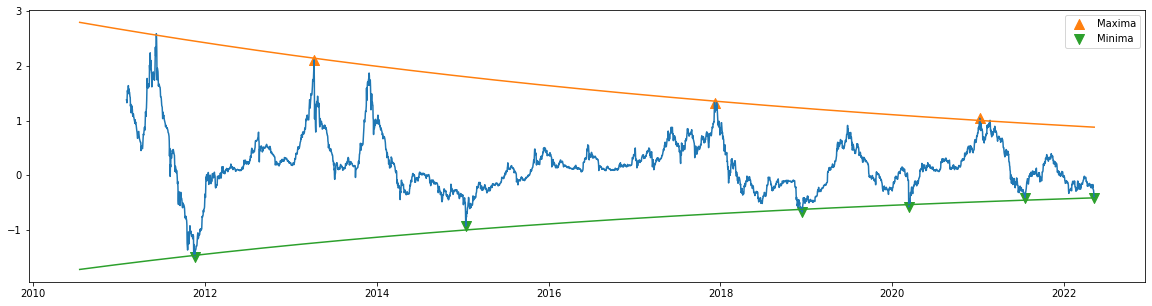

In [ ]:
# Plot the fit data as an overlay on the scatter data

#draw horizontal line across highs and lows

fig, ax = plt.subplots(figsize=(20,5))

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

ax.plot(df['date'],df['log_mayer_multiple'])
ax.scatter(df.iloc[mayer_max_idx]['date'], df.iloc[mayer_max_idx]['log_mayer_multiple'],
  label='Maxima', s=100, color=colors[1], marker='^')
ax.scatter(df.iloc[mayer_min_idx]['date'], df.iloc[mayer_min_idx]['log_mayer_multiple'],
  label='Minima', s=100, color=colors[2], marker='v')
ax.plot(df['date'],df['log_mayer_topband'])
ax.plot(df['date'],df['log_mayer_lowerband'])

ax.legend()

In [ ]:
#adjust mayer multiple to a drecreaseing range using min max normalization https://developers.google.com/machine-learning/data-prep/transform/normalization

adjusted_mayer_multiple_index = []

for i in range(len(df)):
    adjusted_mayer_multiple_index.append((df['log_mayer_multiple'][i]-df['log_mayer_lowerband'][i])/(df['log_mayer_topband'][i]-df['log_mayer_lowerband'][i]))
     

In [ ]:
# add new adjusted mayer multiple to main df

df['adjusted_mayer_multiple_index'] = adjusted_mayer_multiple_index

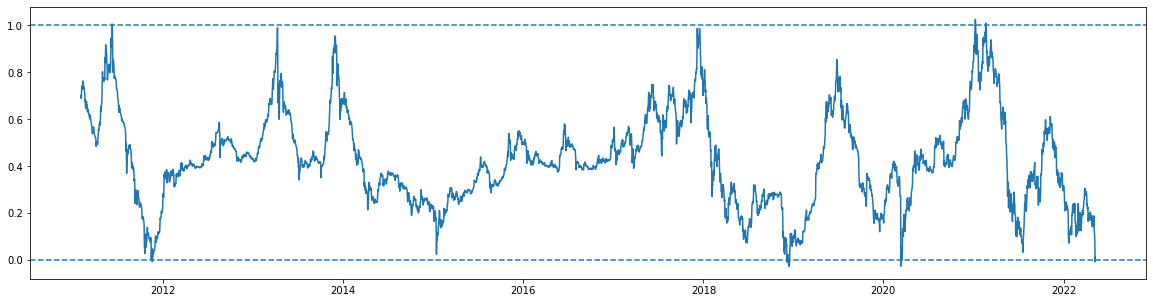

In [ ]:
# plot adjusted mayer index

fig, ax = plt.subplots(figsize=(20,5))

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

ax.plot(df['date'],df['adjusted_mayer_multiple_index'])
ax.axhline(0, linestyle = '--')
ax.axhline(1, linestyle = '--')

No handles with labels found to put in legend.


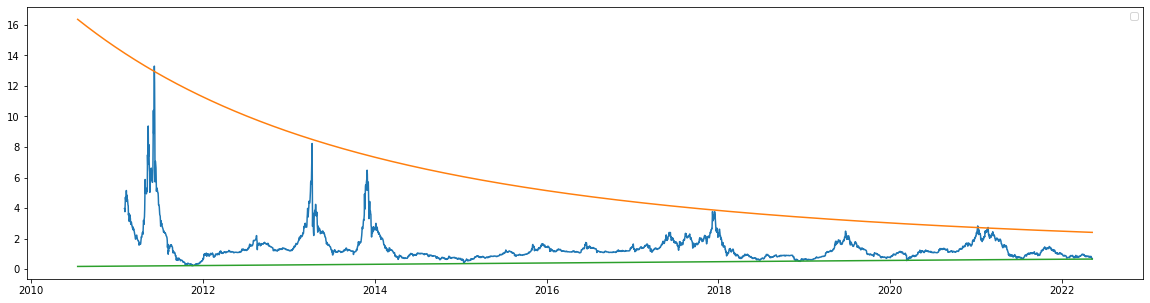

In [ ]:
#draw horizontal log line across highs and lows of the actual Mayer Multiple (using np.exp for the inverse of log)

fig, ax = plt.subplots(figsize=(20,5))

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

ax.plot(df['date'],np.exp(df['log_mayer_multiple']))
ax.plot(df['date'],np.exp(df['log_mayer_topband']))
ax.plot(df['date'],np.exp(df['log_mayer_lowerband']))

ax.legend()

In [ ]:
# calculate new mayer top and lower bands (inverse of log)

df['mayer_topband'] = np.exp(df['log_mayer_topband'])

df['mayer_lowerband'] = np.exp(df['log_mayer_lowerband'])

In [ ]:
df.tail()

,date,open,high,low,close,RSI,50SMA,200SMA,MACD,MACDSignal,MACDHist,StochRSIFastk,StochRSIFastd,mayer_multiple,log_mayer_multiple,log_mayer_topband,log_mayer_lowerband,adjusted_mayer_multiple_index,mayer_topband,mayer_lowerband
4311,2022-05-06,36566.667655,36580.241034,35509.211551,36054.160121,36.794727,41773.688999,46704.148331,-1194.256194,-1025.084284,-169.171910,0.000000,3.333333e+01,0.771969,-0.258811,0.880681,-0.412253,0.118677,2.412543,0.662157
4312,2022-05-07,36039.538853,36124.561488,34944.427399,35542.908407,35.423602,41648.165735,46560.671517,-1324.498696,-1084.967167,-239.531530,0.000000,-1.421085e-13,0.763368,-0.270016,0.880445,-0.412116,0.109937,2.411974,0.662247
4313,2022-05-08,35490.533652,35490.533652,33890.436592,33987.641361,31.569572,41484.119792,46400.626893,-1535.513428,-1175.076419,-360.437009,0.000000,-1.421085e-13,0.732482,-0.311316,0.880210,-0.411980,0.077902,2.411405,0.662338
4314,2022-05-09,34070.852625,34203.515788,30339.983987,30384.579816,24.829777,41266.910187,46240.623957,-1970.763344,-1334.213804,-636.549540,0.000000,-1.421085e-13,0.657097,-0.419923,0.879974,-0.411843,-0.006255,2.410837,0.662428
4315,2022-05-10,30187.990644,32596.307836,29978.213616,31007.755089,27.704605,41065.451079,46092.145585,-2239.600284,-1515.291100,-724.309184,24.027075,8.009025e+00,0.672734,-0.396405,0.879738,-0.411707,0.011848,2.410268,0.662519


In [ ]:
# calculate price bands

df['price_MM_topband'] = df['200SMA']*df['mayer_topband']
df['price_MM_lowerband'] = df['200SMA']*df['mayer_lowerband']

# Mayer Multiple Charts

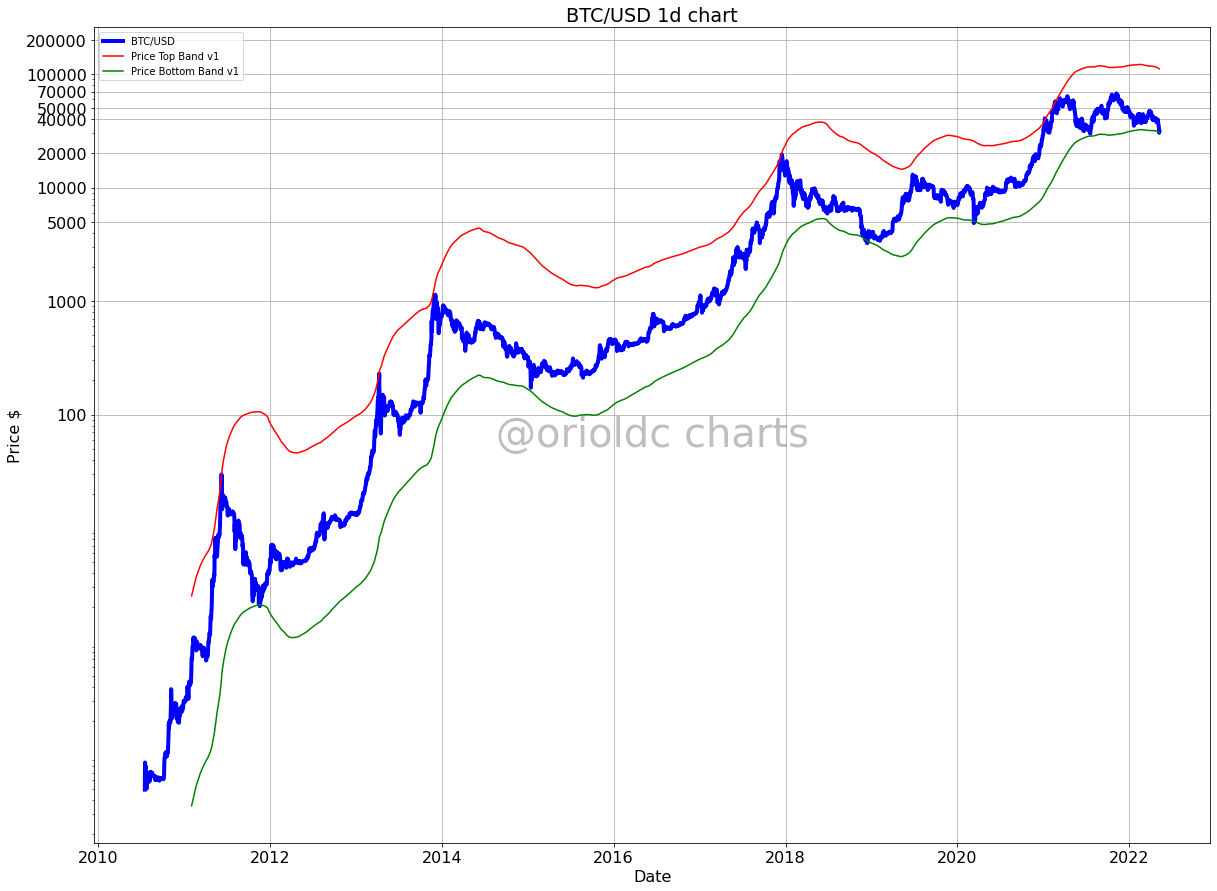

In [ ]:
# visualizing the data so far using matplotlib

plt.rc('font', size=16)

fig, (ax0) = plt.subplots(1,1, sharex=True, figsize=(20,15))

x = df['date']

ticks = [100, 1000, 5000, 10000, 20000, 40000, 50000, 70000,100000,200000]

labels = ['BTC/USD', 'Price Top Band v1', 'Price Bottom Band v1']

yesterday = dt.date.today() - dt.timedelta(days=1)

filename = 'BtcUsd_1d_TopBottomBands_v1_{}.jpg'.format(yesterday)

# plot price, 50-SMA and 200-SMA

ax0.plot(x, df['close'], color='blue', linewidth=4)
ax0.plot(x, df['price_MM_topband'], color='red')
ax0.plot(x, df['price_MM_lowerband'], color='green')
ax0.text(0.5, 0.5, '@orioldc charts', transform=ax0.transAxes,
        fontsize=40, color='gray', alpha=0.5,
        ha='center', va='center')
ax0.set_yscale('log')
ax0.set_yticks(ticks, minor=False)
ax0.yaxis.set_major_formatter(ScalarFormatter()) # removes scientific notation from y-axis
#ax0.set_ticks(ticks, minor=True)
ax0.set_ylabel('Price $')
ax0.set_title('BTC/USD 1d chart')
ax0.legend(labels, loc='upper left', prop={'size': 10})
ax0.set_xlabel('Date')
ax0.grid(True)



# remove vertical gap between subplots
plt.subplots_adjust(hspace=.0)
plt.savefig(filename, facecolor='white', dpi=96)
plt.show()

In [ ]:
# calculate exponential moving averages

df['50EMA'] = df['close'].ewm(span=50, adjust=False).mean()
df['100EMA'] = df['close'].ewm(span=100, adjust=False).mean()
df['200EMA'] = df['close'].ewm(span=200, adjust=False).mean()

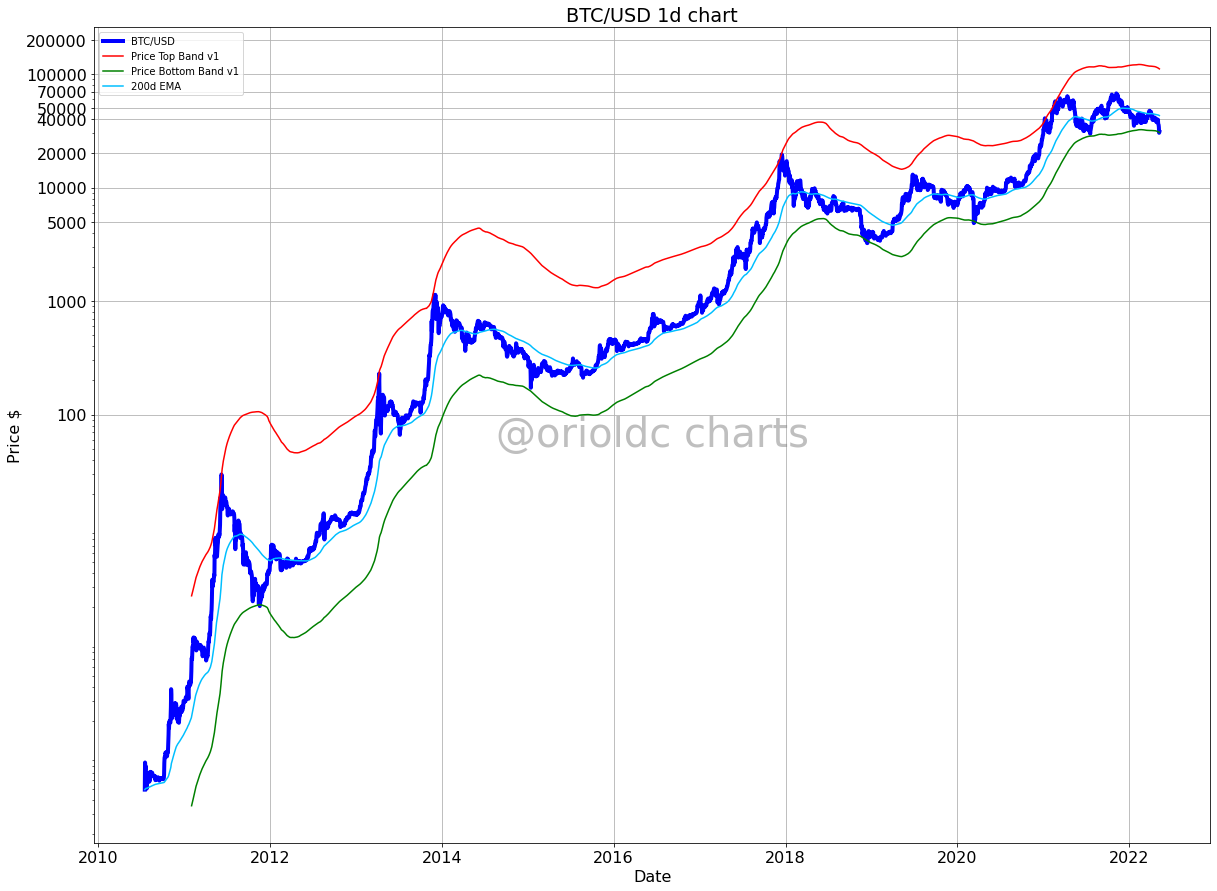

In [ ]:
# visualizing the data so far using matplotlib

plt.rc('font', size=16)

fig, (ax0) = plt.subplots(1,1, sharex=True, figsize=(20,15))

x = df['date']

ticks = [100, 1000, 5000, 10000, 20000, 40000, 50000, 70000,100000,200000]

labels = ['BTC/USD', 'Price Top Band v1', 'Price Bottom Band v1', '200d EMA']

yesterday = dt.date.today() - dt.timedelta(days=1)

filename = 'BtcUsd_1d_TopBottomBands_uptrendsupport_v1_{}.jpg'.format(yesterday)

# plot price, 50-SMA and 200-SMA

ax0.plot(x, df['close'], color='blue', linewidth=4)
ax0.plot(x, df['price_MM_topband'], color='red')
ax0.plot(x, df['price_MM_lowerband'], color='green')
#ax0.plot(x, df['50EMA'], color='brown')
#ax0.plot(x, df['100EMA'], color='orange')
ax0.plot(x, df['200EMA'], color='deepskyblue')
ax0.text(0.5, 0.5, '@orioldc charts', transform=ax0.transAxes,
        fontsize=40, color='gray', alpha=0.5,
        ha='center', va='center')
ax0.set_yscale('log')
ax0.set_yticks(ticks, minor=False)
ax0.yaxis.set_major_formatter(ScalarFormatter()) # removes scientific notation from y-axis
#ax0.set_ticks(ticks, minor=True)
ax0.set_ylabel('Price $')
ax0.set_title('BTC/USD 1d chart')
ax0.legend(labels, loc='upper left', prop={'size': 10})
ax0.set_xlabel('Date')
ax0.grid(True)



# remove vertical gap between subplots
plt.subplots_adjust(hspace=.0)
plt.savefig(filename, facecolor='white', dpi=96)
plt.show()

# Realized Price

In [ ]:
# import realized price data from glassnode going back to 2013

# API key here
API_KEY = '' #insert your glassnode API KEY here

# report end dates

yesterday = dt.date.today() - dt.timedelta(days=1)
unixtimeyesterday = round(time.mktime(yesterday.timetuple()))

today = dt.date.today()
unixtimetoday = round(time.mktime(today.timetuple()))

# make API request
res = requests.get('https://api.glassnode.com/v1/metrics/market/price_realized_usd',
        params={'a': 'BTC', 'api_key': API_KEY, 's': '1278716400', 'u': unixtimetoday,
            'i': '24h','f':'JSON', 'timestamp_format':'unix'})

# convert to pandas dataframe
df_rp = pd.read_json(res.text)

#rename columns

df_rp = df_rp.rename(columns={'t':'date', 'v':'realized_price'})

# transform unix to UTC

df_rp['date'] = pd.to_datetime(df_rp['date'],unit='s')

In [ ]:
#add realized price data to the main dataframe

df['realized_price'] = df_rp['realized_price']

# calcualte current price to realized price ratio

df['btcprice_realizedprice_ratio'] = df['close']/df['realized_price']

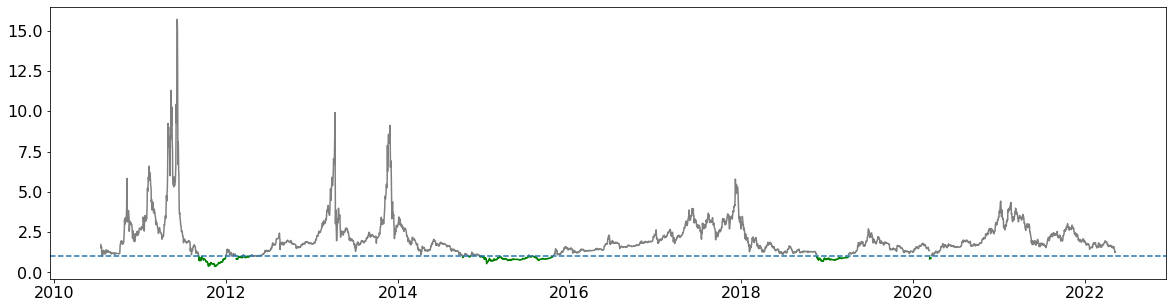

In [ ]:
# plot btc price to realized price ratio

fig, ax = plt.subplots(figsize=(20,5))

y_rp = df['btcprice_realizedprice_ratio']

pr_1_plus = y_rp.copy() # create two different lines for above one and below one
pr_1_minus = y_rp.copy()

pr_1_plus[pr_1_plus <= 1] = np.nan # convert numbers above and below to np.nan
pr_1_minus[pr_1_plus >= 1] = np.nan

ax.plot(df['date'],pr_1_plus, color='grey')
ax.plot(df['date'],pr_1_minus, color='green')
ax.axhline(1, linestyle="--")


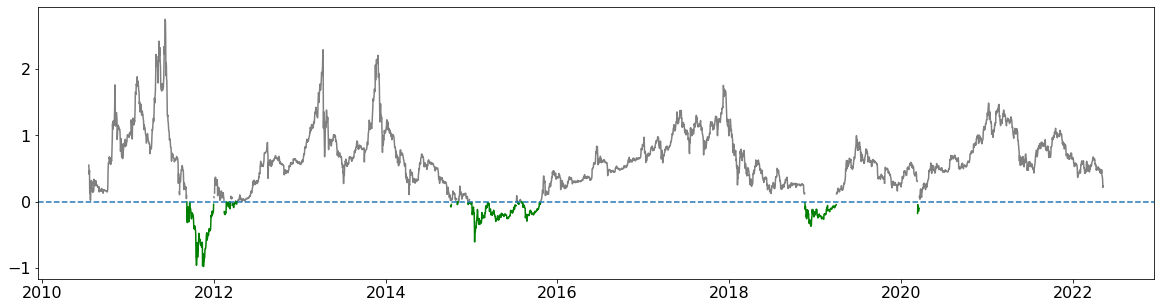

In [ ]:
# plot btc price to realized price ratio

fig, ax = plt.subplots(figsize=(20,5))

y_rp = np.log(df['btcprice_realizedprice_ratio'])

pr_1_plus = y_rp.copy() # create two different lines for above one and below one
pr_1_minus = y_rp.copy()

pr_1_plus[pr_1_plus <= 0] = np.nan # convert numbers above and below to np.nan
pr_1_minus[pr_1_plus >= 0] = np.nan

ax.plot(df['date'],pr_1_plus, color='grey')
ax.plot(df['date'],pr_1_minus, color='green')
ax.axhline(0, linestyle="--")

In [ ]:
# create new field for log realized price

df['log_realized_price_ratio'] = np.log(df['btcprice_realizedprice_ratio'])

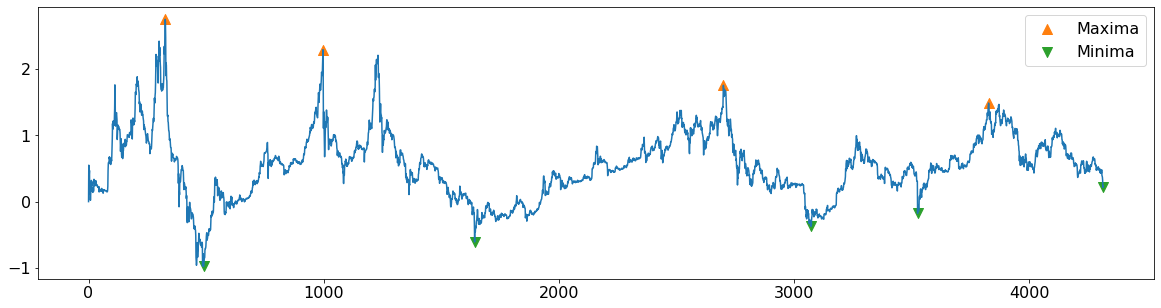

In [ ]:
# plot local maxima and minima using https://medium.com/raposa-technologies/higher-highs-lower-lows-and-calculating-price-trends-in-python-9bc9703f46a1

from scipy.signal import argrelextrema

realized_max_idx = argrelextrema(df['log_realized_price_ratio'].values, 
  np.greater, order=600)[0]
realized_min_idx = argrelextrema(df['log_realized_price_ratio'].values, 
  np.less, order=350)[0]

fig, ax = plt.subplots(figsize=(20,5))

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

ax.plot(np.log(df['btcprice_realizedprice_ratio']))
ax.scatter(df.iloc[realized_max_idx].index, df.iloc[realized_max_idx]['log_realized_price_ratio'],
  label='Maxima', s=100, color=colors[1], marker='^')
ax.scatter(df.iloc[realized_min_idx].index, df.iloc[realized_min_idx]['log_realized_price_ratio'],
  label='Minima', s=100, color=colors[2], marker='v')
ax.legend()

In [ ]:
# create pd series with log mayer multiple highs and lows

realized_highs = df.iloc[realized_max_idx]['log_realized_price_ratio']
realized_lows = df.iloc[realized_min_idx]['log_realized_price_ratio']

# remove last value from realized lows

realized_lows = realized_lows[:-1]

print(realized_lows)

489    -0.979774
1642   -0.609789
3072   -0.373236
3526   -0.179084
Name: log_realized_price_ratio, dtype: float64


In [ ]:
# transform high and low series to dataframe, to then calculate a linear regression across them

realized_highs = pd.DataFrame(realized_highs)

realized_lows = pd.DataFrame(realized_lows)

realized_highs

,log_realized_price_ratio
326,2.753888
997,2.294909
2700,1.756547
3828,1.488130


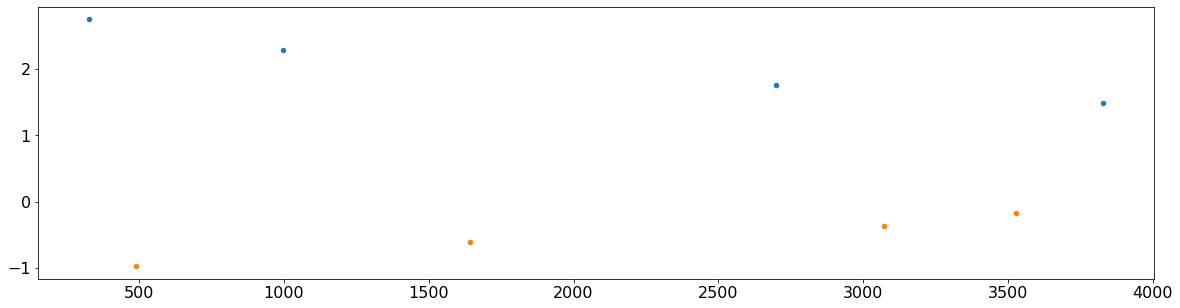

In [ ]:
#plot maxima and minima of the log mayer multiple

fig, ax = plt.subplots(figsize=(20,5))

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

ax.scatter(realized_highs.index, realized_highs['log_realized_price_ratio'], s=20)
ax.scatter(realized_lows.index, realized_lows['log_realized_price_ratio'], s=20)

In [ ]:
# Function to calculate the exponential with constants a and b
def exponential(x, a, b):
    return a*np.exp(b*x)

# from https://towardsdatascience.com/basic-curve-fitting-of-scientific-data-with-python-9592244a2509

from scipy.optimize import curve_fit
x_top = realized_highs.index
y_top = realized_highs['log_realized_price_ratio']

x_low = realized_lows.index
y_low = realized_lows['log_realized_price_ratio']

#Fit the dummy exponential data
pars, cov = curve_fit(f=exponential, xdata=x_top, ydata=y_top, p0=[0, 0], bounds=(-np.inf, np.inf))

#Fit the dummy exponential data
pars_low, cov_low = curve_fit(f=exponential, xdata=x_low, ydata=y_low, p0=[0, 0], bounds=(-np.inf, np.inf))


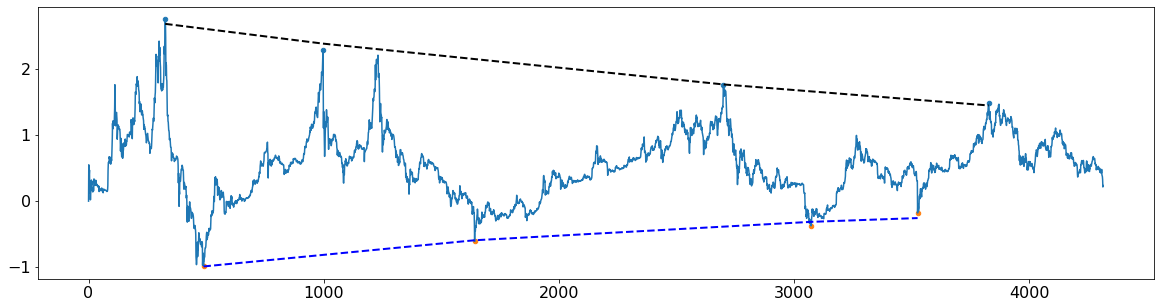

In [ ]:
# Plot the fit data as an overlay on the scatter data

fig, ax = plt.subplots(figsize=(20,5))
ax.plot(df['log_realized_price_ratio'])
ax.plot(x_top, exponential(x_top, *pars), linestyle='--', linewidth=2, color='black')
ax.plot(x_low, exponential(x_low, *pars_low), linestyle='--', linewidth=2, color='blue')
ax.scatter(realized_highs.index, realized_highs['log_realized_price_ratio'], s=20)
ax.scatter(realized_lows.index, realized_lows['log_realized_price_ratio'], s=20)
plt.show()

In [ ]:
# define log top band and log lower band

x = df.index

df['log_realized_topband'] = exponential(x, *pars)
df['log_realized_lowerband'] = exponential(x, *pars_low)

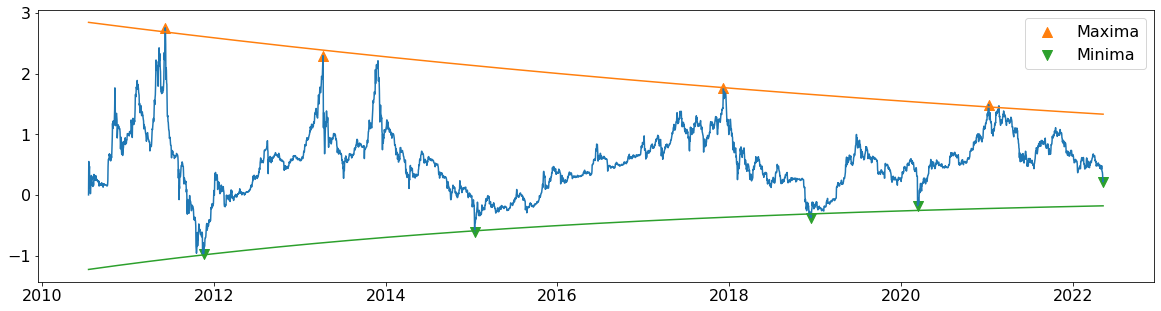

In [ ]:
# Plot the fit data as an overlay on the scatter data

#draw horizontal line across highs and lows

fig, ax = plt.subplots(figsize=(20,5))

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

ax.plot(df['date'],df['log_realized_price_ratio'])
ax.scatter(df.iloc[realized_max_idx]['date'], df.iloc[realized_max_idx]['log_realized_price_ratio'],
  label='Maxima', s=100, color=colors[1], marker='^')
ax.scatter(df.iloc[realized_min_idx]['date'], df.iloc[realized_min_idx]['log_realized_price_ratio'],
  label='Minima', s=100, color=colors[2], marker='v')
ax.plot(df['date'],df['log_realized_topband'])
ax.plot(df['date'],df['log_realized_lowerband'])

ax.legend()

In [ ]:
#adjust price to realized price ratio to a drecreaseing range using min max normalization https://developers.google.com/machine-learning/data-prep/transform/normalization

price_realized_index = []

for i in range(len(df)):
    price_realized_index.append((df['log_realized_price_ratio'][i]-df['log_realized_lowerband'][i])/(df['log_realized_topband'][i]-df['log_realized_lowerband'][i]))

# add new adjusted mayer multiple to main df

df['price_realized_index'] = price_realized_index

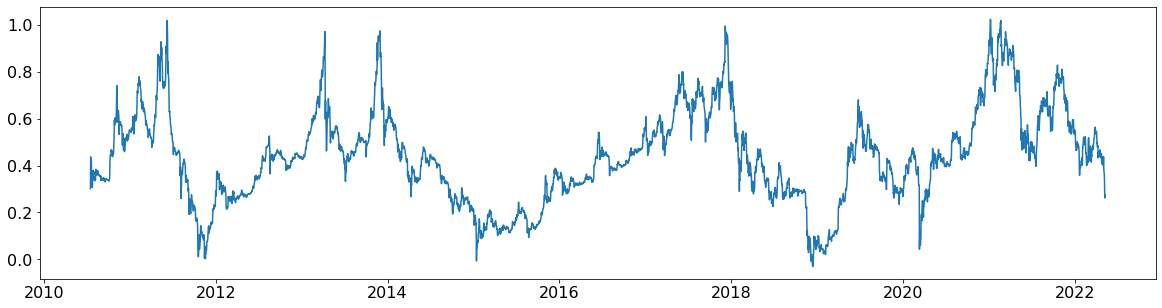

In [ ]:
# plot adjusted realized price index

fig, ax = plt.subplots(figsize=(20,5))

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

ax.plot(df['date'],df['price_realized_index'])

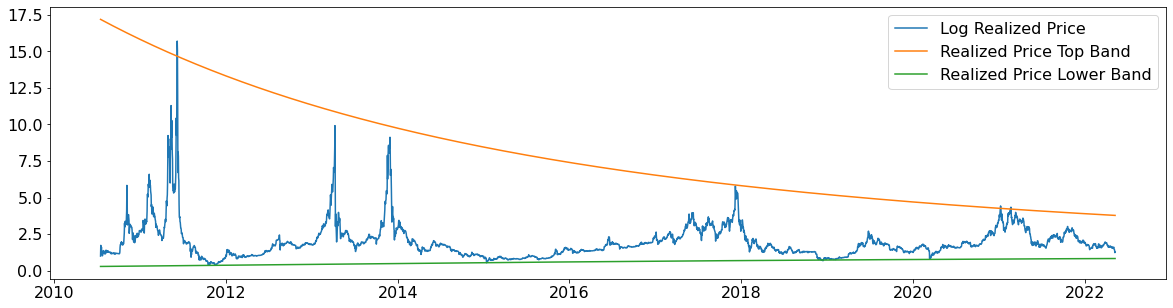

In [ ]:
# Plot the fit data as an overlay on the scatter data

#draw horizontal line across highs and lows

fig, ax = plt.subplots(figsize=(20,5))

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

ax.plot(df['date'],np.exp(df['log_realized_price_ratio']), label='Log Realized Price')
ax.plot(df['date'],np.exp(df['log_realized_topband']), label='Realized Price Top Band')
ax.plot(df['date'],np.exp(df['log_realized_lowerband']), label='Realized Price Lower Band')

ax.legend()

In [ ]:
# calculate new price to realized price and lower bands (inverse of log)

df['realized_topband'] = np.exp(df['log_realized_topband'])

df['realized_lowerband'] = np.exp(df['log_realized_lowerband'])

df.tail()

,date,open,high,low,close,RSI,50SMA,200SMA,MACD,MACDSignal,...,100EMA,200EMA,realized_price,btcprice_realizedprice_ratio,log_realized_price_ratio,log_realized_topband,log_realized_lowerband,price_realized_index,realized_topband,realized_lowerband
4311,2022-05-06,36566.667655,36580.241034,35509.211551,36054.160121,36.794727,41773.688999,46704.148331,-1194.256194,-1025.084284,...,41804.054021,43520.859015,24549.647745,1.468622,0.384325,1.331475,-0.180822,0.373701,3.786625,0.834584
4312,2022-05-07,36039.538853,36124.561488,34944.427399,35542.908407,35.423602,41648.165735,46560.671517,-1324.498696,-1084.967167,...,41680.070939,43441.476422,24530.587531,1.448922,0.370820,1.331241,-0.180741,0.364793,3.785737,0.834651
4313,2022-05-08,35490.533652,35490.533652,33890.436592,33987.641361,31.569572,41484.119792,46400.626893,-1535.513428,-1175.076419,...,41527.745601,43347.408411,24523.018040,1.385949,0.326385,1.331006,-0.180661,0.335422,3.784850,0.834718
4314,2022-05-09,34070.852625,34203.515788,30339.983987,30384.579816,24.829777,41266.910187,46240.623957,-1970.763344,-1334.213804,...,41307.088853,43218.425042,24510.566159,1.239652,0.214831,1.330772,-0.180581,0.261628,3.783963,0.834785
4315,2022-05-10,30187.990644,32596.307836,29978.213616,31007.755089,27.704605,41065.451079,46092.145585,-2239.600284,-1515.291100,...,41103.141650,43096.925839,24478.457388,1.266736,0.236444,1.330538,-0.180500,0.275932,3.783077,0.834852


In [ ]:
# calculate price bands

df['price_R_topband'] = df['realized_price']*df['realized_topband']
df['price_R_lowerband'] = df['realized_price']*df['realized_lowerband']

# Realized Price Charts

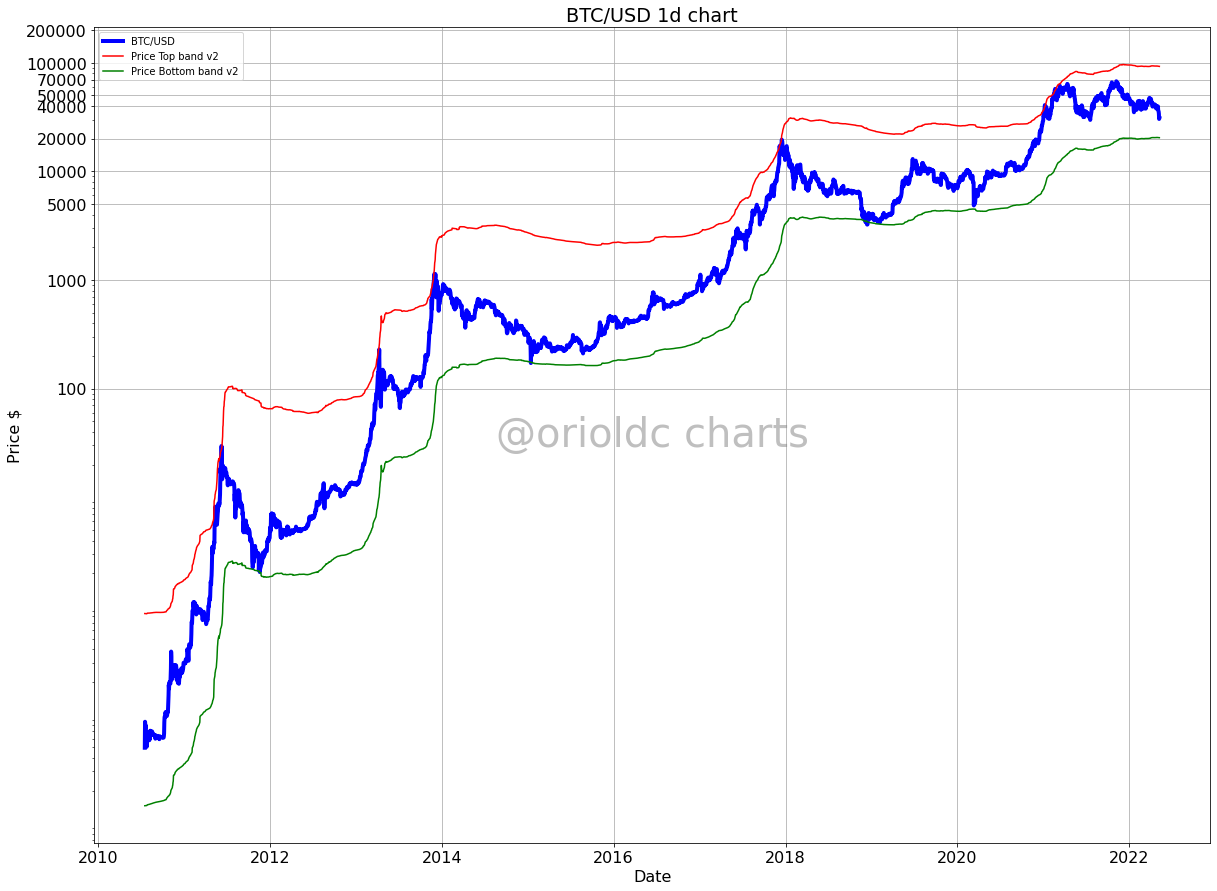

In [ ]:
# visualizing the data so far using matplotlib

plt.rc('font', size=16)

fig, (ax0) = plt.subplots(1,1, sharex=True, figsize=(20,15))

x = df['date']

ticks = [100, 1000, 5000, 10000, 20000, 40000, 50000, 70000,100000,200000]

labels = ['BTC/USD', 'Price Top band v2', 'Price Bottom band v2', 'Realized Price']

yesterday = dt.date.today() - dt.timedelta(days=1)

filename = 'BtcUsd_1d_TopBottomBands_v2_{}.jpg'.format(yesterday)

# plot price, 50-SMA and 200-SMA

ax0.plot(x, df['close'], color='blue', linewidth=4)
ax0.plot(x, df['price_R_topband'], color='red')
ax0.plot(x, df['price_R_lowerband'], color='green')
#ax0.plot(x, df['50EMA'], color='brown')
#ax0.plot(x, df['100EMA'], color='orange')
#ax0.plot(x, df['realized_price'], color='deepskyblue')
ax0.text(0.5, 0.5, '@orioldc charts', transform=ax0.transAxes,
        fontsize=40, color='gray', alpha=0.5,
        ha='center', va='center')
ax0.set_yscale('log')
ax0.set_yticks(ticks, minor=False)
ax0.yaxis.set_major_formatter(ScalarFormatter()) # removes scientific notation from y-axis
#ax0.set_ticks(ticks, minor=True)
ax0.set_ylabel('Price $')
ax0.set_title('BTC/USD 1d chart')
ax0.legend(labels, loc='upper left', prop={'size': 10})
ax0.set_xlabel('Date')
ax0.grid(True)



# remove vertical gap between subplots
plt.subplots_adjust(hspace=.0)
#plt.savefig(filename, facecolor='white', dpi=96)
plt.show()

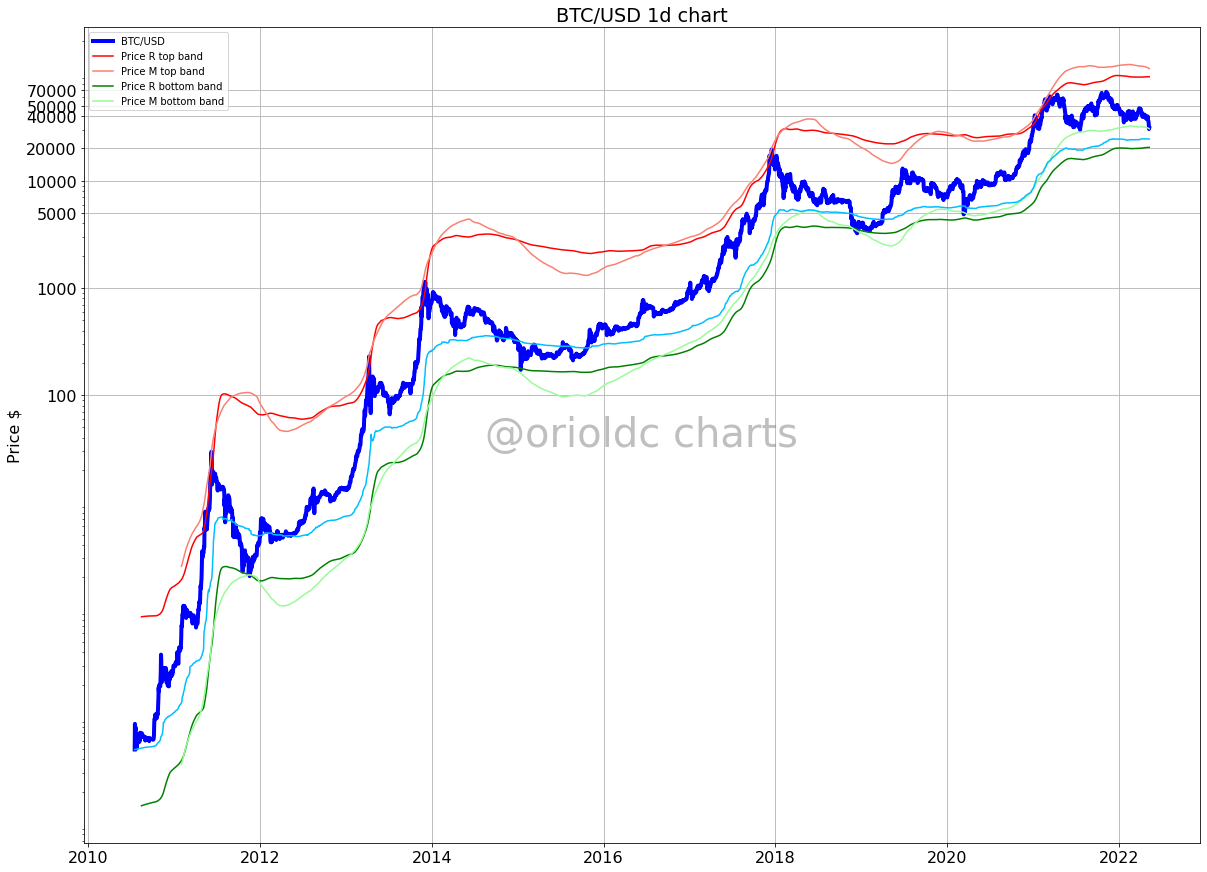

In [ ]:
# visualizing the data so far using matplotlib

plt.rc('font', size=16)

fig, (ax0) = plt.subplots(1,1, sharex=True, figsize=(20,15))

x = df['date']

ticks = [100, 1000, 5000, 10000, 20000, 40000, 50000, 70000]

labels = ['BTC/USD', 'Price R top band', 'Price M top band','Price R bottom band','Price M bottom band']

yesterday = dt.date.today() - dt.timedelta(days=1)

filename = 'BtcUsd_1d_{}.jpg'.format(yesterday)

# plot price, 50-SMA and 200-SMA

ax0.plot(x, df['close'], color='blue', linewidth=4)
ax0.plot(x, df['price_R_topband'].rolling(window=30).mean(), color='red')
ax0.plot(x, df['price_MM_topband'], color='salmon')
ax0.plot(x, df['price_R_lowerband'].rolling(window=30).mean(), color='green')
ax0.plot(x, df['price_MM_lowerband'], color='palegreen')
#ax0.plot(x, df['50EMA'], color='brown')
#ax0.plot(x, df['100EMA'], color='orange')
ax0.plot(x, df['realized_price'], color='deepskyblue')
ax0.text(0.5, 0.5, '@orioldc charts', transform=ax0.transAxes,
        fontsize=40, color='gray', alpha=0.5,
        ha='center', va='center')
ax0.set_yscale('log')
ax0.set_yticks(ticks, minor=False)
ax0.yaxis.set_major_formatter(ScalarFormatter()) # removes scientific notation from y-axis
#ax0.set_ticks(ticks, minor=True)
ax0.set_ylabel('Price $')
ax0.set_title('BTC/USD 1d chart')
ax0.legend(labels, loc='upper left', prop={'size': 10})
ax0.grid(True)



# remove vertical gap between subplots
plt.subplots_adjust(hspace=.0)
#plt.savefig(filename, facecolor='white', dpi=96)
plt.show()

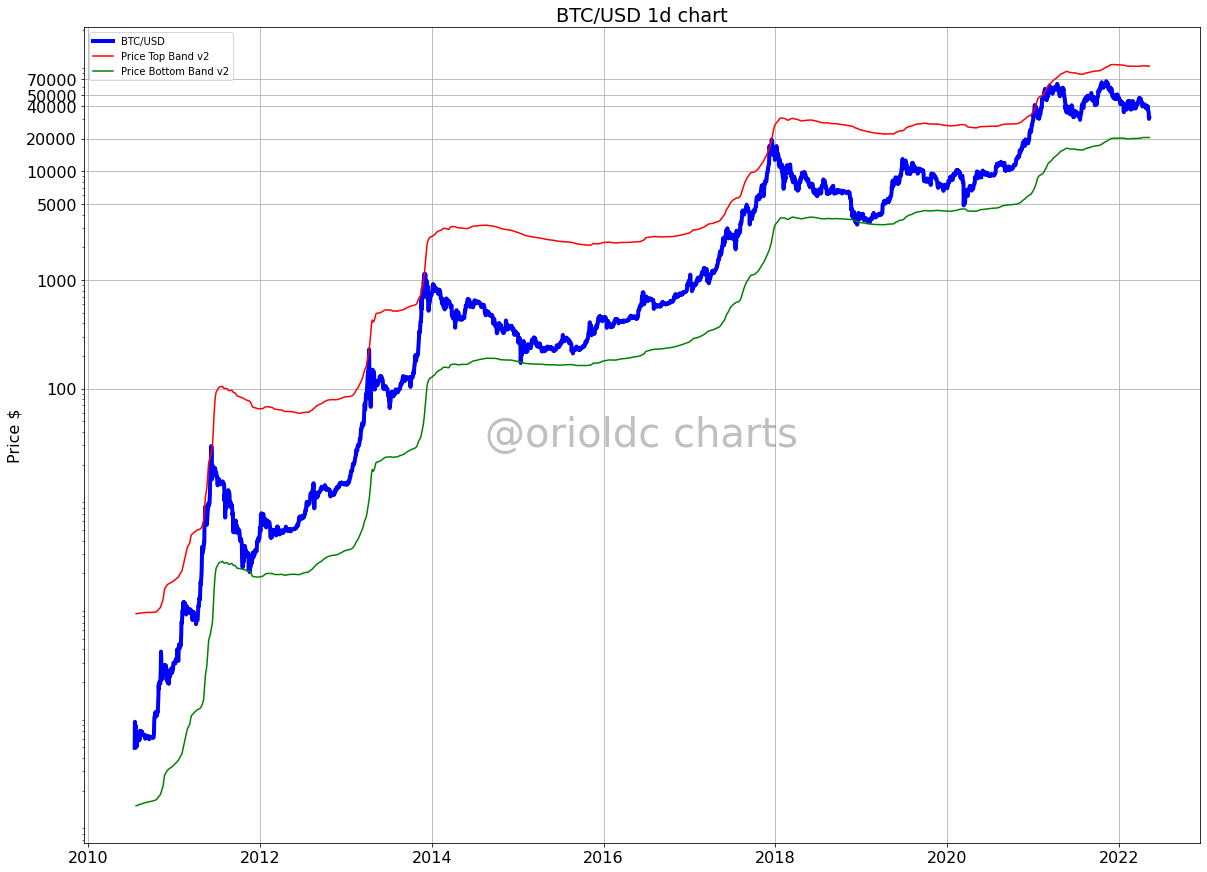

In [ ]:
# visualizing the data so far using matplotlib

plt.rc('font', size=16)

fig, (ax0) = plt.subplots(1,1, sharex=True, figsize=(20,15))

x = df['date']

ticks = [100, 1000, 5000, 10000, 20000, 40000, 50000, 70000]

labels = ['BTC/USD', 'Price Top Band v2','Price Bottom Band v2']

yesterday = dt.date.today() - dt.timedelta(days=1)

filename = 'BtcUsd_1d_TopBottomBands_v2_{}.jpg'.format(yesterday)

# plot price, 50-SMA and 200-SMA

ax0.plot(x, df['close'], color='blue', linewidth=4)
ax0.plot(x, df['price_R_topband'].rolling(window=7).mean(), color='red')
ax0.plot(x, df['price_R_lowerband'].rolling(window=7).mean(), color='green')
#ax0.plot(x, df['50EMA'], color='brown')
#ax0.plot(x, df['100EMA'], color='orange')
ax0.text(0.5, 0.5, '@orioldc charts', transform=ax0.transAxes,
        fontsize=40, color='gray', alpha=0.5,
        ha='center', va='center')
ax0.set_yscale('log')
ax0.set_yticks(ticks, minor=False)
ax0.yaxis.set_major_formatter(ScalarFormatter()) # removes scientific notation from y-axis
#ax0.set_ticks(ticks, minor=True)
ax0.set_ylabel('Price $')
ax0.set_title('BTC/USD 1d chart')
ax0.legend(labels, loc='upper left', prop={'size': 10})
ax0.grid(True)



# remove vertical gap between subplots
plt.subplots_adjust(hspace=.0)
plt.savefig(filename, facecolor='white', dpi=96)
plt.show()

In [ ]:
df[['date','close','price_R_topband','price_R_lowerband','price_MM_topband', 'price_MM_lowerband','200EMA']].tail()

,date,close,price_R_topband,price_R_lowerband,price_MM_topband,price_MM_lowerband,200EMA
4311,2022-05-06,36054.160121,92960.309911,20488.746420,112675.751531,30925.474174,43520.859015
4312,2022-05-07,35542.908407,92866.364096,20474.484639,112303.114440,30834.680365,43441.476422
4313,2022-05-08,33987.641361,92815.951708,20469.811217,111890.702226,30732.886305,43347.408411
4314,2022-05-09,30384.579816,92747.086889,20461.060434,111478.585796,30631.090106,43218.425042
4315,2022-05-10,31007.755089,92603.889543,20435.896784,111094.441748,30536.899406,43096.925839


#200W SMA

In [ ]:
# add weekday to main df

df['weekday'] = df['date'].dt.dayofweek

In [ ]:
# calculate week date alternative approach

week_date = []
week_close = []

for i, (date, weekday, close) in enumerate(zip(df['date'], df['weekday'], df['close'])):
    if weekday == 0:
        week_date.append(date)
        week_close.append(close)

In [ ]:
# build new week df

week_dic = {'week_date': week_date, 'week_close': week_close}

weeks_df = pd.DataFrame(data=week_dic)

# calculate 200-week MA

twohundred__week_sma = weeks_df['week_close'].rolling(window=200).mean()

# append to the week dataframe

weeks_df['200_week_SMA'] = twohundred__week_sma

In [ ]:
# rename datefield before doing left join

weeks_df = weeks_df.rename(columns={'week_date':'date'})

# left join weekly closes and 200week SMA

df = pd.merge(df, 
              weeks_df, 
              on ='date', 
              how ='left')

In [ ]:
# fill empty values with the previous one https://stackoverflow.com/questions/27905295/how-to-replace-nans-by-preceding-or-next-values-in-pandas-dataframe

df['200_week_SMA'].fillna(method='ffill', inplace=True)
df['week_close'].fillna(method='ffill', inplace=True)

In [ ]:
# calculate price vs 200W SMA ratio

df['price_200WSMA_ratio'] = df['close']/df['200_week_SMA']

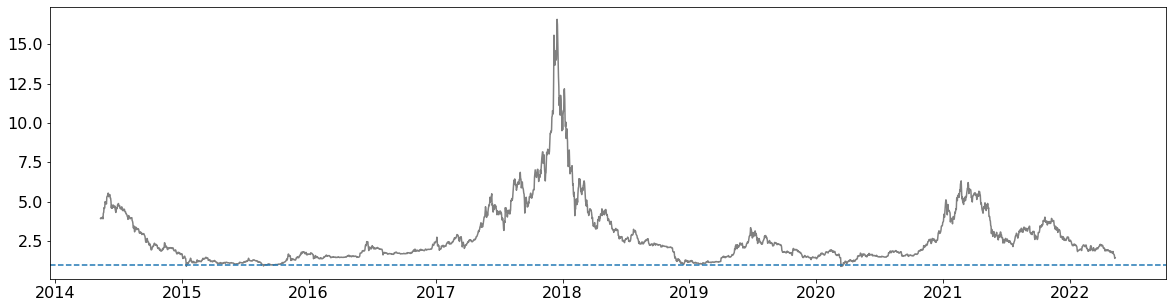

In [ ]:
# plot 200W SMA

fig, ax = plt.subplots(figsize=(20,5))

#y_rp = df['price_200WSMA_ratio']

#pr_1_plus = y_rp.copy() # create two different lines for above one and below one
#pr_1_minus = y_rp.copy()

#pr_1_plus[pr_1_plus <= 1] = np.nan # convert numbers above and below to np.nan
#pr_1_minus[pr_1_plus >= 1] = np.nan

ax.plot(df['date'],df['price_200WSMA_ratio'], color='grey')
#ax.plot(df['date'],pr_1_minus, color='green')
ax.axhline(1, linestyle="--")


#New mayer multiple view

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

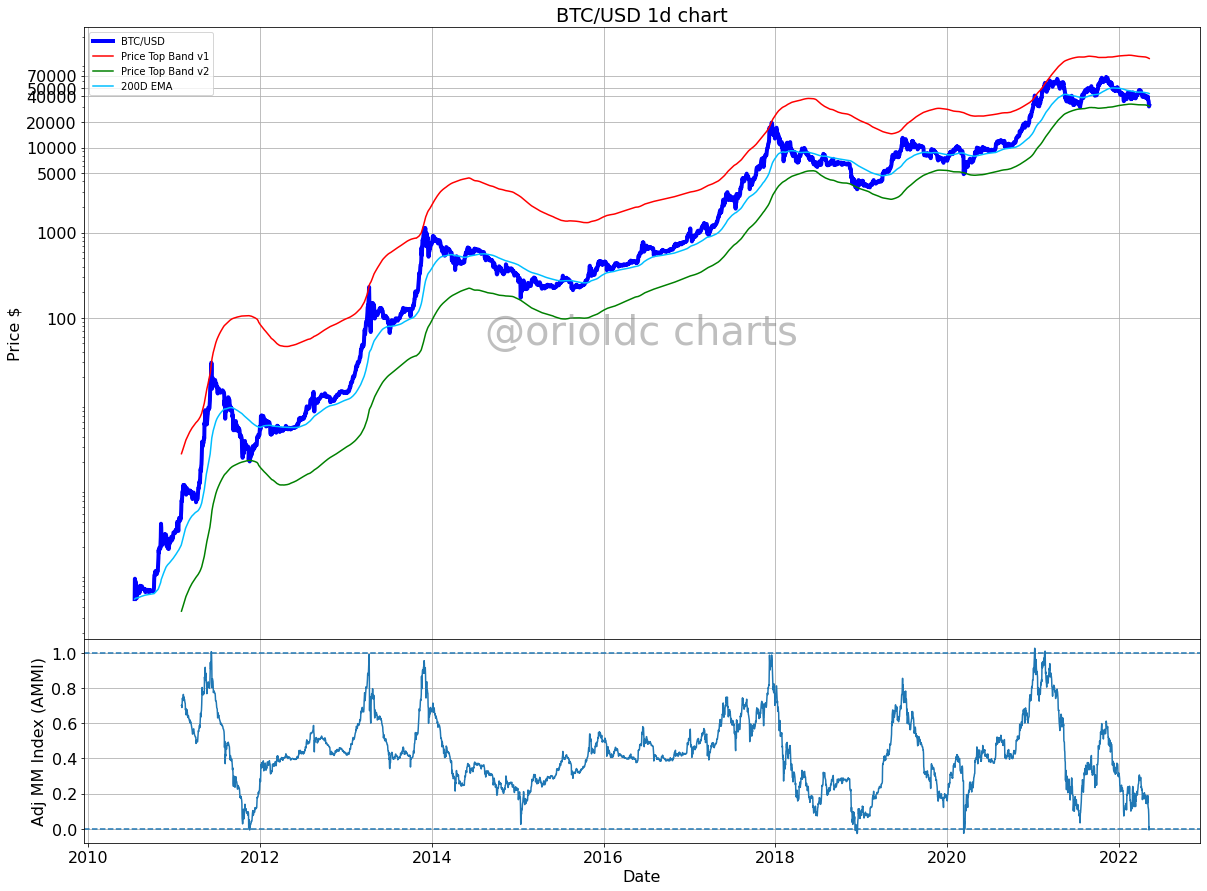

In [ ]:
# visualizing the data so far using matplotlib

plt.rc('font', size=16)

fig, (ax0, ax1) = plt.subplots(2,1, sharex=True, gridspec_kw={'height_ratios': [3, 1]}, figsize=(20,15))

x = df['date']

ticks = [100, 1000, 5000, 10000, 20000, 40000, 50000, 70000]

labels = ['BTC/USD', 'Price Top Band v1', 'Price Top Band v2', '200D EMA']

yesterday = dt.date.today() - dt.timedelta(days=1)

filename = 'BtcUsd_1d_BTC_by_MM_{}.jpg'.format(yesterday)

# plot price, mayer multiple bands and uptrend 200d MA

ax0.plot(x, df['close'], color='blue', linewidth=4) #price
ax0.plot(x, df['price_MM_topband'], color='red') #mm top band
ax0.plot(x, df['price_MM_lowerband'], color='green') #mm lower band
ax0.plot(x, df['200EMA'], color='deepskyblue') #support lines in uptrends
ax0.text(0.5, 0.5, '@orioldc charts', transform=ax0.transAxes,
        fontsize=40, color='gray', alpha=0.5,
        ha='center', va='center')
ax0.set_yscale('log')
ax0.set_yticks(ticks, minor=False)
ax0.yaxis.set_major_formatter(ScalarFormatter()) # removes scientific notation from y-axis
#ax0.set_ticks(ticks, minor=True)
ax0.set_ylabel('Price $')
ax0.set_title('BTC/USD 1d chart')
ax0.legend(labels, loc='upper left', prop={'size': 10})
ax0.grid(True)

# plot mayer multiple index

ax1.plot(df['date'],df['adjusted_mayer_multiple_index'])
ax1.axhline(0, linestyle = '--')
ax1.axhline(1, linestyle = '--')
ax1.set_ylabel('Adj MM Index (AMMI)')
ax1.set_xlabel('Date')
ax1.grid(True)

# remove vertical gap between subplots
plt.subplots_adjust(hspace=.0)
plt.savefig(filename, facecolor='white', dpi=96)
files.download(filename)
plt.show()


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

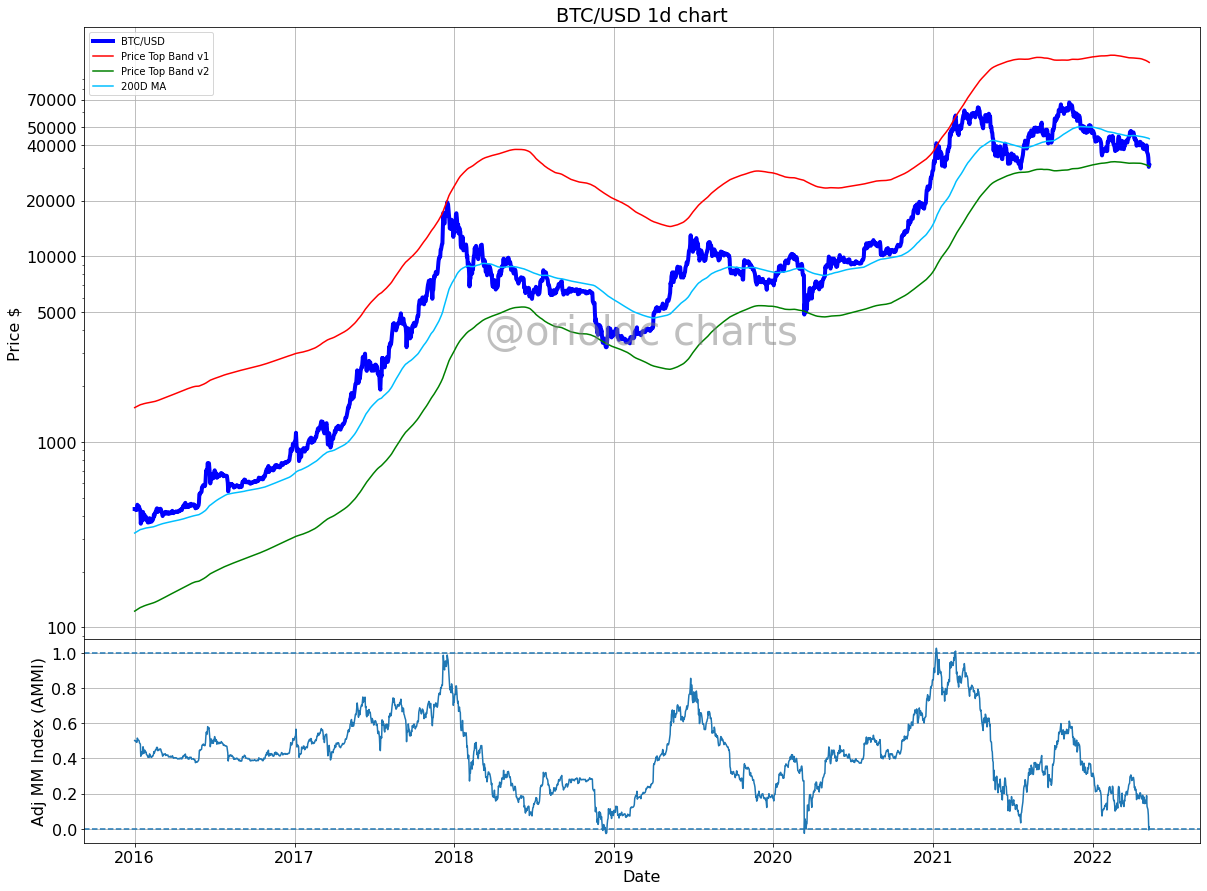

In [ ]:
# data=df.loc[~df.year.isin([1991, 2008]), :]

# visualizing the data so far using matplotlib

# Filter data between two dates
df_2016 = df.loc[(df['date'] >= '2016-01-01')]

plt.rc('font', size=16)

fig, (ax0, ax1) = plt.subplots(2,1, sharex=True, gridspec_kw={'height_ratios': [3, 1]}, figsize=(20,15))

x = df_2016['date']

ticks = [100, 1000, 5000, 10000, 20000, 40000, 50000, 70000]

labels = ['BTC/USD', 'Price Top Band v1', 'Price Top Band v2', '200D MA']

yesterday = dt.date.today() - dt.timedelta(days=1)

filename = 'BtcUsd_1d_BTC_by_MM_2016_{}.jpg'.format(yesterday)

# plot price, mayer multiple bands and uptrend 200d MA

ax0.plot(x, df_2016['close'], color='blue', linewidth=4) #price
ax0.plot(x, df_2016['price_MM_topband'], color='red') #mm top band
ax0.plot(x, df_2016['price_MM_lowerband'], color='green') #mm lower band
ax0.plot(x, df_2016['200EMA'], color='deepskyblue') #support lines in uptrends
ax0.text(0.5, 0.5, '@orioldc charts', transform=ax0.transAxes,
        fontsize=40, color='gray', alpha=0.5,
        ha='center', va='center')
ax0.set_yscale('log')
ax0.set_yticks(ticks, minor=False)
ax0.yaxis.set_major_formatter(ScalarFormatter()) # removes scientific notation from y-axis
#ax0.set_ticks(ticks, minor=True)
ax0.set_ylabel('Price $')
ax0.set_title('BTC/USD 1d chart')
ax0.legend(labels, loc='upper left', prop={'size': 10})
ax0.grid(True)

# plot mayer multiple index

ax1.plot(x,df_2016['adjusted_mayer_multiple_index'])
ax1.axhline(0, linestyle = '--')
ax1.axhline(1, linestyle = '--')
ax1.set_ylabel('Adj MM Index (AMMI)')
ax1.set_xlabel('Date')
ax1.grid(True)

# remove vertical gap between subplots
plt.subplots_adjust(hspace=.0)
plt.savefig(filename, facecolor='white', dpi=96)
files.download(filename) 
plt.show()


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

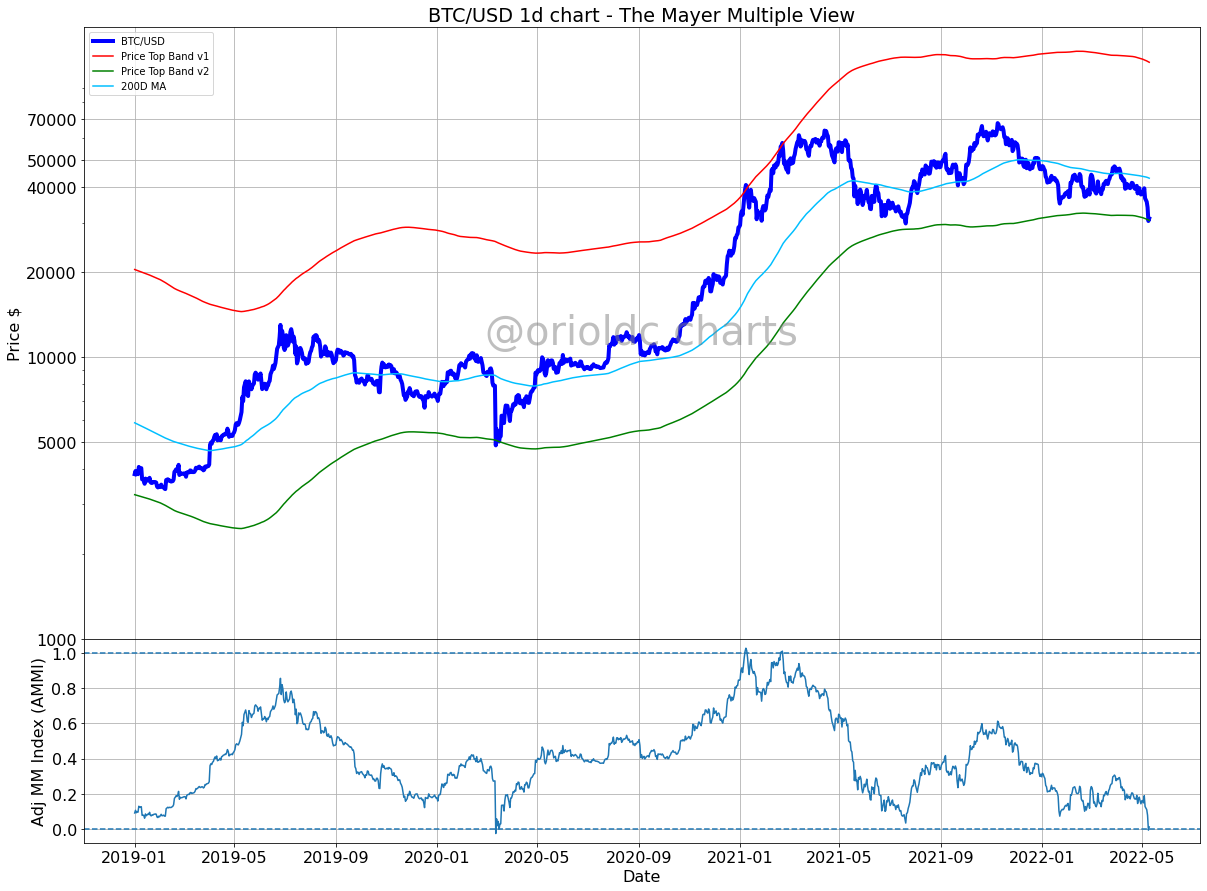

In [ ]:


# visualizing the data so far using matplotlib

# Filter data between two dates
df_2019 = df.loc[(df['date'] >= '2019-01-01')]

plt.rc('font', size=16)

fig, (ax0, ax1) = plt.subplots(2,1, sharex=True, gridspec_kw={'height_ratios': [3, 1]}, figsize=(20,15))

x = df_2019['date']

ticks = [1000,5000, 10000, 20000, 40000, 50000, 70000]

labels = ['BTC/USD', 'Price Top Band v1', 'Price Top Band v2', '200D MA']

yesterday = dt.date.today() - dt.timedelta(days=1)

filename = 'BtcUsd_1d_BTC_by_MM_2019_{}.jpg'.format(yesterday)

# plot price, mayer multiple bands and uptrend 200d MA

ax0.plot(x, df_2019['close'], color='blue', linewidth=4) #price
ax0.plot(x, df_2019['price_MM_topband'], color='red') #mm top band
ax0.plot(x, df_2019['price_MM_lowerband'], color='green') #mm lower band
ax0.plot(x, df_2019['200EMA'], color='deepskyblue') #support lines in uptrends
ax0.text(0.5, 0.5, '@orioldc charts', transform=ax0.transAxes,
        fontsize=40, color='gray', alpha=0.5,
        ha='center', va='center')
ax0.set_yscale('log')
ax0.set_yticks(ticks, minor=False)
ax0.yaxis.set_major_formatter(ScalarFormatter()) # removes scientific notation from y-axis
#ax0.set_ticks(ticks, minor=True)
ax0.set_ylabel('Price $')
ax0.set_title('BTC/USD 1d chart - The Mayer Multiple View')
ax0.legend(labels, loc='upper left', prop={'size': 10})
ax0.grid(True)

# plot mayer multiple index

ax1.plot(x,df_2019['adjusted_mayer_multiple_index'])
ax1.axhline(0, linestyle = '--')
ax1.axhline(1, linestyle = '--')
ax1.set_ylabel('Adj MM Index (AMMI)')
ax1.set_xlabel('Date')
ax1.grid(True)

# remove vertical gap between subplots
plt.subplots_adjust(hspace=.0)

#save figure google colab
from google.colab import files
plt.savefig(filename, facecolor='white', dpi=96)
files.download(filename) 
plt.show()


In [ ]:
# print metrics that matter

metrics = df[['date','high','close','200EMA','adjusted_mayer_multiple_index','price_MM_topband','price_MM_lowerband']]

metrics.tail(5)

,date,high,close,200EMA,adjusted_mayer_multiple_index,price_MM_topband,price_MM_lowerband
4311,2022-05-06,36580.241034,36054.160121,43520.859015,0.118677,112675.751531,30925.474174
4312,2022-05-07,36124.561488,35542.908407,43441.476422,0.109937,112303.114440,30834.680365
4313,2022-05-08,35490.533652,33987.641361,43347.408411,0.077902,111890.702226,30732.886305
4314,2022-05-09,34203.515788,30384.579816,43218.425042,-0.006255,111478.585796,30631.090106
4315,2022-05-10,32596.307836,31007.755089,43096.925839,0.011848,111094.441748,30536.899406
